In [12]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/bbc-20210425T015848Z-001.zip

Archive:  /content/drive/MyDrive/bbc-20210425T015848Z-001.zip
  inflating: bbc/entertainment/306.txt  
  inflating: bbc/entertainment/289.txt  
  inflating: bbc/entertainment/369.txt  
  inflating: bbc/tech/013.txt        
  inflating: bbc/tech/367.txt        
  inflating: bbc/entertainment/318.txt  
  inflating: bbc/tech/135.txt        
  inflating: bbc/tech/052.txt        
  inflating: bbc/tech/108.txt        
  inflating: bbc/tech/115.txt        
  inflating: bbc/tech/334.txt        
  inflating: bbc/tech/279.txt        
  inflating: bbc/entertainment/297.txt  
  inflating: bbc/entertainment/305.txt  
  inflating: bbc/entertainment/347.txt  
  inflating: bbc/tech/063.txt        
  inflating: bbc/tech/368.txt        
  inflating: bbc/tech/119.txt        
  inflating: bbc/tech/288.txt        
  inflating: bbc/tech/068.txt        
  inflating: bbc/entertainment/310.txt  
  inflating: bbc/entertainment/329.txt  
  inflating: bbc/entertainment/313.txt  
  inflating: bbc/tech/160.txt     

In [14]:
# For reproducibility
np.random.seed(1237)
import pathlib
# Source file directory
path_train = "/content/bbc"

files_train = skds.load_files(path_train,load_content=False)

label_index = files_train.target
label_names = files_train.target_names
labelled_files = files_train.filenames
print(label_index)
data_tags = ["filename","category","news"]
data_list = []

# Read and add data from file to a list
i=0
for f in labelled_files:
  data_list.append((f,label_names[label_index[i]],pathlib.Path(f).read_text()))
  i += 1

# We have training data available as dictionary filename, category, data
data = pd.DataFrame.from_records(data_list, columns=data_tags)
data

[3 0 0 ... 3 1 1]


,filename,category,news
0,/content/bbc/tech/087.txt,tech,Net regulation 'still possible'\n\nThe blurrin...
1,/content/bbc/business/377.txt,business,VW considers opening Indian plant\n\nVolkswage...
2,/content/bbc/business/010.txt,business,Court rejects $280bn tobacco case\n\nA US gove...
3,/content/bbc/business/309.txt,business,AstraZeneca hit by drug failure\n\nShares in A...
4,/content/bbc/business/300.txt,business,J&J agrees $25bn Guidant deal\n\nPharmaceutica...
...,...,...,...
1515,/content/bbc/politics/004.txt,politics,Labour chooses Manchester\n\nThe Labour Party ...
1516,/content/bbc/politics/076.txt,politics,Report attacks defence spending\n\nThe Ministr...
1517,/content/bbc/tech/077.txt,tech,"Rich pickings for hi-tech thieves\n\nViruses, ..."
1518,/content/bbc/entertainment/180.txt,entertainment,McCririck out of Big Brother show\n\nRacing pu...


In [ ]:
# import pandas
# import os
# cat=[]
# news = []

# cat = os.listdir('/content/drive/My Drive/text classification/bbc')
# print(cat)
# file = os.listdir('/content/drive/My Drive/text classification/bbc/business')
# print(file)

In [ ]:

# for j in file:
#   for i in cat:
    
#     b = open(f"/content/drive/My Drive/text classification/bbc/{i}/{j}",encoding='utf-8')
#     c = b.read()
#     cat.append('business')
#     news.append(c)

# data = {'category':cat,'news':news}
# data = pandas.DataFrame(data)
# data

In [15]:
# lets take 80% data as training and remaining 20% for test.
train_size = int(len(data) * .8)
 
train_posts = data['news'][:train_size]
train_tags = data['category'][:train_size]
train_files_names = data['filename'][:train_size]
 
test_posts = data['news'][train_size:]
test_tags = data['category'][train_size:]
test_files_names = data['filename'][train_size:]        #no change

In [16]:
# 20 news groups
num_labels = 4
vocab_size = 15000
batch_size = 100
 
# define Tokenizer with Vocab Size              #no chnage
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)
 
x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')
 
encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [18]:
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               7680512   
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_8 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

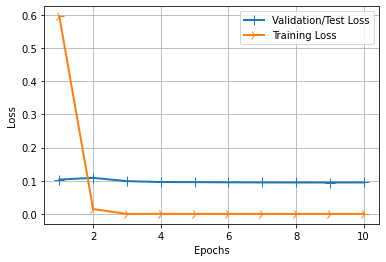

In [19]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

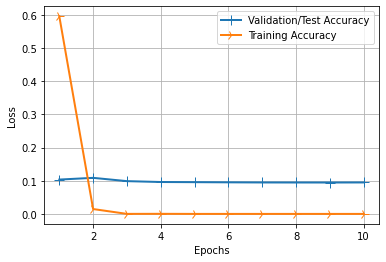

In [20]:
# Plotting our acuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
acc_loss_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, loss_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test accuracy:', score[1])

text_labels = encoder.classes_

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    print(test_files_names.iloc[i])
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label)

4/4 [==============================] - 0s 7ms/step - loss: 0.1245 - accuracy: 0.9803
Test accuracy: 0.9802631735801697
/content/bbc/tech/283.txt
Actual label:tech
Predicted label: tech
/content/bbc/entertainment/076.txt
Actual label:entertainment
Predicted label: entertainment
/content/bbc/entertainment/205.txt
Actual label:entertainment
Predicted label: entertainment
/content/bbc/business/148.txt
Actual label:business
Predicted label: business
/content/bbc/business/161.txt
Actual label:business
Predicted label: business
/content/bbc/politics/352.txt
Actual label:politics
Predicted label: politics
/content/bbc/entertainment/371.txt
Actual label:entertainment
Predicted label: entertainment
/content/bbc/politics/358.txt
Actual label:politics
Predicted label: politics
/content/bbc/politics/100.txt
Actual label:politics
Predicted label: politics
/content/bbc/politics/193.txt
Actual label:politics
Predicted label: politics


In [22]:
# creates a HDF5 file 'my_model.h5'
model = model.save('my_model.h5')
 
# Save Tokenizer i.e. Vocabulary
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# load our saved model
from keras.models import load_model
model = load_model('my_model.h5')
 
# load tokenizer
tokenizer = Tokenizer()
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
    
encoder.classes_ #LabelBinarizer

array(['business', 'entertainment', 'politics', 'tech'], dtype='<U13')

In [24]:
# These are the labels we stored from our training
# The order is very important here.
 
labels = np.array(['business', 'entertainment', 'politics', 'tech'])
 
test_files = ["/content/news.txt"]
x_data = []
for t_f in test_files:
    t_f_data = Path(t_f).read_text()
    x_data.append(t_f_data)
 
x_data_series = pd.Series(x_data)
x_tokenized = tokenizer.texts_to_matrix(x_data_series, mode='tfidf')
 
i=0
for x_t in x_tokenized:
    prediction = model.predict(np.array([x_t]))
    predicted_label = labels[np.argmax(prediction[0])]
    print(prediction)
    print("File ->", test_files[i], "Predicted label: " + predicted_label)

[[0.12303993 0.00987325 0.07555245 0.7915343 ]]
File -> /content/news.txt Predicted label: tech


/content/drive/My Drive/text classification


In [ ]:
import pandas
import os
cat=[]
news = []

cat = os.listdir('/content/drive/My Drive/text classification/bbc')

cat.remove('sport')
print(cat)
file = os.listdir('/content/drive/My Drive/text classification/bbc/business')
print(file)

['business', 'entertainment', 'politics', 'tech']
['247.txt', '337.txt', '301.txt', '328.txt', '152.txt', '123.txt', '353.txt', '308.txt', '190.txt', '313.txt', '070.txt', '321.txt', '329.txt', '258.txt', '225.txt', '217.txt', '155.txt', '101.txt', '344.txt', '380.txt', '358.txt', '310.txt', '277.txt', '067.txt', '091.txt', '241.txt', '239.txt', '338.txt', '267.txt', '047.txt', '186.txt', '098.txt', '198.txt', '268.txt', '280.txt', '342.txt', '213.txt', '359.txt', '244.txt', '179.txt', '004.txt', '317.txt', '351.txt', '339.txt', '231.txt', '232.txt', '142.txt', '243.txt', '238.txt', '105.txt', '035.txt', '160.txt', '057.txt', '054.txt', '021.txt', '187.txt', '201.txt', '175.txt', '269.txt', '042.txt', '129.txt', '150.txt', '032.txt', '093.txt', '087.txt', '205.txt', '294.txt', '058.txt', '246.txt', '075.txt', '154.txt', '284.txt', '349.txt', '372.txt', '052.txt', '002.txt', '141.txt', '156.txt', '218.txt', '245.txt', '083.txt', '371.txt', '085.txt', '028.txt', '099.txt', '374.txt', '16

In [ ]:

c =0
for j in file:
  # for i in cat:
    
    b = open(f"/content/drive/My Drive/text classification/bbc/tech/{j}",encoding='utf-8')
    
    c = b.read()
    cat.append(i)
    news.append(c)
    
data4 = {'news':news}
data4 = pandas.DataFrame(data4)
data4

,news
0,Renault boss hails 'great year'\n\nStrong sale...
1,Building giant in asbestos payout\n\nAustralia...
2,Libya takes $1bn in unfrozen funds\n\nLibya ha...
3,Bush to get 'tough' on deficit\n\nUS president...
4,Crude oil prices back above $50\n\nCold weathe...
...,...
1515,Microsoft takes on desktop search\n\nMicrosoft...
1516,Halo 2 heralds traffic explosion\n\nThe growin...
1517,More power to the people says HP\n\nThe digita...
1518,Mobile picture power in your pocket\n\nHow man...


In [ ]:
data4 = pandas.DataFrame(data4)
data4

ValueError: ignored

In [ ]:
data1 = data.sample(frac=1)

In [ ]:
data2 = data2.sample(frac=1)

In [ ]:
data3 = data3.sample(frac=1)

In [ ]:
data4 = data4.sample(frac=1)

In [ ]:
final_data = pandas.concat([data1,data2,data3,data4])
final_data

,news
66,Wall Street cheers Bush victory\n\nThe US stoc...
346,Jobs growth still slow in the US\n\nThe US cre...
309,Fresh hope after Argentine crisis\n\nThree yea...
127,Car giant hit by Mercedes slump\n\nA slump in ...
77,Industrial revival hope for Japan\n\nJapanese ...
...,...
16,Macy's owner buys rival for $11bn\n\nUS retail...
28,Nasdaq planning $100m share sale\n\nThe owner ...
152,Soaring oil 'hits world economy'\n\nThe soarin...
156,Cuba winds back economic clock\n\nFidel Castro...


In [ ]:
import pickle
import sys
dict={1:'hello',2:'2'}
file_1=open('file1','wb')
pickle.dump(dict,file_1)
file_1.close()

file_2=open('file1','rb')
obj=pickle.load(file_2)
print(obj)
file_2.close()


{1: 'hello', 2: '2'}


In [ ]:
data4 = data4.sample(frac=1)
data4

,news
1195,A question of trust and technology\n\nA major ...
1231,"Yahoo celebrates a decade online\n\nYahoo, one..."
1433,Games firms 'face tough future'\n\nUK video ga...
787,Lib Dems highlight problem debt\n\nPeople vuln...
93,S Korean credit card firm rescued\n\nSouth Kor...
...,...
89,Ukraine revisits state sell-offs\n\nUkraine is...
71,Iraqi voters turn to economic issues\n\nBeyond...
201,Safety alert as GM recalls cars\n\nThe world's...
1104,UKIP candidate suspended in probe\n\nEuroscept...
